# **HW5: Autoencoders**

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version of it. Next, we will experiment with the application of a denoising autoencoder. Finally, we will experiment with sequential domains, considering the IMDB dataset, alredy used in HW4.

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
Each value is between 0 and 255, and represents a pixel in an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, we will split the test set, in the test and validation set.

In [0]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

##Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW we will focus our attention on SVD decomposition. Indeed it is more numerical stable. Given a matrix X, the SVD decomposes a matrix into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T$$

SVD is implemented in NumPy as np.linalg.svd. In our case the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that the X matrix, in our case, will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore, to optimize the memory consumption we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we can relate the decomposition of the covariance matrix $C= X^T \cdot X$ to the decomposition of $X$. In fact

$$ C= X^T \cdot X = U \cdot S \cdot V^T \cdot V\cdot S \cdot U^T  = U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the Colab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [0]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data, and compute the compressed version of the training set and the test set.

**To complete: What happens varying the ENCODING_DIM? test  and discuss the results in this cell**

In [0]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images

In [0]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [0]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [0]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed, by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images shows input data, while the second one shows the reconstructions.

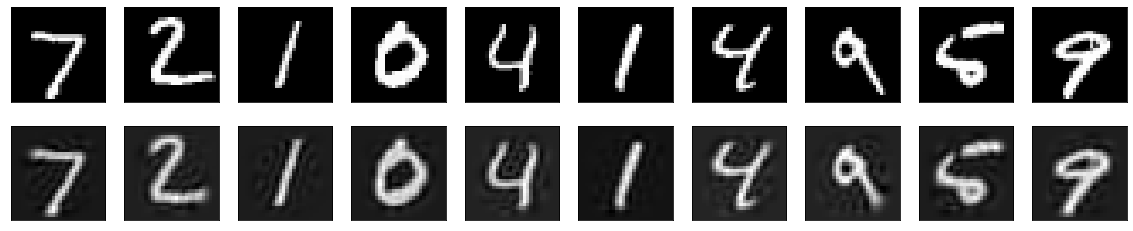

In [0]:
plot_img(10, x_test, x_test_reco)

#**Discussion**:
Here below I reported two different results obtained with ENCODING_DIM = 50 and ENCODING_DIM = 200 on the same test set.

###ENCODING_DIM = 50 (test mse: 0.01150)

![immagine5 0](https://user-images.githubusercontent.com/53294518/83273875-49fe6d80-a1cd-11ea-88eb-bb163ce9610e.png)


###ENCODING_DIM = 200 (test mse: 0.00224)

![immagine5 0_2](https://user-images.githubusercontent.com/53294518/83273918-5a164d00-a1cd-11ea-8c45-8a06d04ed609.png)

I tried other values too. I noticed that,for example, ENCODING_DIM = 1000 the test mse is equal to 0.0000, in which there is almost no difference between x_test e x_test reconstructed. 

These results show even more strongly that as ENCONDING_DIM increases, the quality of the representation increases and mse decreases (mean squared error).

## Exercise 5.1: Shallow Linear Autoencoder
Let's define the model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various parts of the model (encoder and decoder) separately and create the final model. 

**To complete: check the results and compare them with the results obtained by SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.**


In [0]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [0]:
autoencoder.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_16 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [0]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0432 - val_loss: 0.0147
Epoch 2/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 3/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 1s 7ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 5/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 9/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 11/15
98/98 [

Plot the loss and the accuracy curves, and the accuracy on the test set.

In [0]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0049
test mse: 0.00493


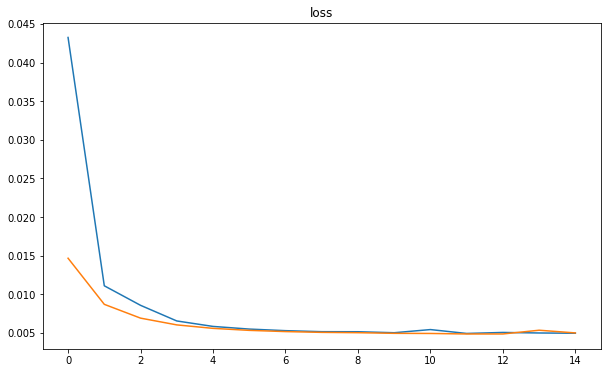

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

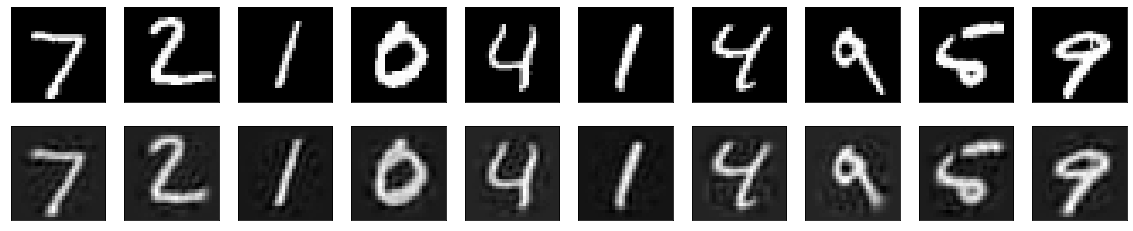

In [0]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


#**Discussion**

Before to start to discuss the relation between PCA and Shallow Linear Autoencoder, I reported the two different results obtained from the two methods with the same dimension, ENCODING_DIM = 120 and on the same test set.

###PCA (SVD) (test mse: 0.00455)

![uno](https://user-images.githubusercontent.com/53294518/83275747-e6c20a80-a1cf-11ea-925e-9c0dd322de90.png)

###Shallow Linear Autoencoder (test mse: 0.00493)

![due](https://user-images.githubusercontent.com/53294518/83275793-f2adcc80-a1cf-11ea-8bd8-edc622b40450.png)


From the images obtained by the two methods we obtain that they are very similar if not equal from a visual point of view. This our supposition is confirmed by the comparison of the two methods that are approximately equal.

In order to demonstrate this relationship, it is sufficient to consider a feed forward network with a single hidden layer (h) and a linear activation function.

Therefore:
1. x = input
2. A = input weights matrix -> hidden
3. B = hidden weights matrix -> output 

Since we are working in the world of autoencoders whose aim is to learn a more efficient representation of input you will have that 
$$o = A \cdot B \cdot x$$

Since o = x, where o = rebuilt input, you will have 
$$x = A \cdot B \cdot x$$

For this to apply, you will have $$A= B^T$$ 

So we can rewrite, 
$$o= A \cdot B \cdot x  =  A^T \cdot A \cdot x$$  


As for the PCA decomposition, it compute the encoded representation of the input and the reconstruction of this input becomes 

$$o (= reconstructed input) = U^T \cdot U \cdot x.$$ 





Putting $$A = U$$ we will have that the methods are equivalent, giving therefore more or less the same results, as shown in the results of the mse that is approximately equal.


##Exercise  5.2: Shallow non-linear autoencoders

**To complete: replicate the code of exercise 5.1 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1.**


In [0]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded_1 = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded_1 = tf.keras.layers.Dense(784, activation='sigmoid')(encoded_1)

#and finally the autoencoder
autoencoder_1 = tf.keras.models.Model(input_img, decoded_1)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder_1 = tf.keras.models.Model(input_img, encoded_1)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder_1.layers[-1]
decoder_1 = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [0]:
autoencoder_1.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_21 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_22 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("\nTrain the model\n")
history_1 = autoencoder_1.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))


Train the model

Epoch 1/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0555 - val_loss: 0.0362
Epoch 2/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0292 - val_loss: 0.0231
Epoch 3/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0199 - val_loss: 0.0168
Epoch 4/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0150 - val_loss: 0.0131
Epoch 5/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 0.0107
Epoch 6/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0099 - val_loss: 0.0091
Epoch 7/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 8/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 9/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0059
E

313/313 - 0s - loss: 0.0042
test mse: 0.00424


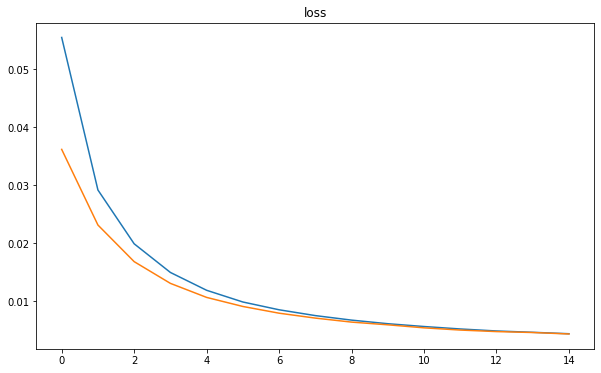

In [0]:
plot_loss(history_1)

scores_1 = autoencoder_1.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores_1))

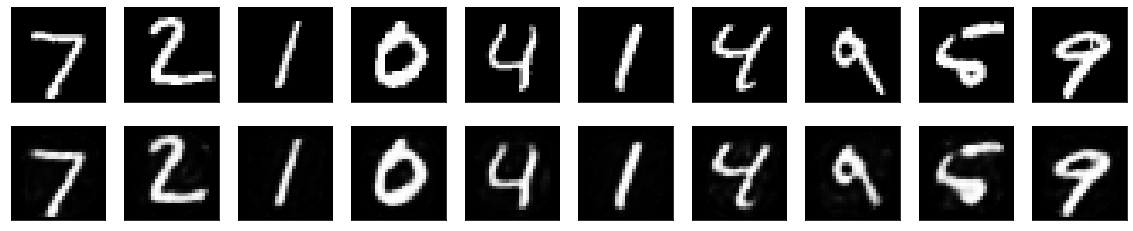

In [0]:
encoded_imgs = encoder_1.predict(x_test)
decoded_imgs = decoder_1.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

#**Discussion**

Here below I reported the two results about Shallow linear autoencoders and Shallow non-linear autoencoders.

###Shallow Linear Autoencoder (test mse: 0.00493)

![due](https://user-images.githubusercontent.com/53294518/83275793-f2adcc80-a1cf-11ea-8bd8-edc622b40450.png)


###Shallow Non-Linear Autoencoder (test mse: 0.00424)

![aaaqa](https://user-images.githubusercontent.com/53294518/83352061-2fe99a00-a349-11ea-8c69-c4173c989151.png)



Even if the mean squared error is similar you can see that having the same type of ENCODING_DIM = 120 the result for non-linear shallow autoencoders gives a better representation, less blurred. This is dictated by the fact that with a non-linear activation function you can model a more complex space.

I also tested several activation functions: tahn, ReLu, RMSprop, sigmoid. At the end I choose sigmoid because from the results I got a lower loss as well as a lower mse.


## Exercise 5.3: Deep Autoencoder
**To_complete: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (e.g., 748->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e, 128->748, the resulting structure recall an hourglass).
Similarly than what did above, print the model summary, the loss curve during the training, the achieved loss on the test set, and some input image with the correspondent decoding.**


In [0]:
######hyperparameters#####################################
epoch_deep_autoencoder=150
layer_encoded = 4
layer_decoded = (layer_encoded -2)
activation_function="relu"
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_function=["mse","binary_crossentropy"]
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
##########################################################


input_img = tf.keras.layers.Input(shape=(784,))
layer_start_encoded = input_img
encoded=[]
i = 1
h= 512
print("\n\nEncoding\n\n")
while i <= layer_encoded:
  print(f"Layer n°{i} Encoding with activation function: {activation_function} and number of units: {str(h)}")
  encoded.append(tf.keras.layers.Dense(int(h), activation=activation_function)(layer_start_encoded))
  layer_start_encoded = encoded[-1]
  i = i + 1
  h = h /2


layer_start_decoded =encoded[-1]
decoded=[]
j = 1
h = h * 4
print("\n\nDecoding\n\n")
while j <= (layer_decoded):
  print(f"Layer n°{j} Decoding with activation function: {activation_function} and number of units: {str(h)}")
  decoded.append(tf.keras.layers.Dense(int(h), activation=activation_function)(layer_start_decoded))
  layer_start_decoded = decoded[-1]
  j = j + 1
  h = h * 2

decoded_finale= tf.keras.layers.Dense(784, activation='sigmoid')(decoded[-1])
print(f"Layer n°{j} Decoding with activation function: sigmoid and number of units: 784")
autoencoder = tf.keras.models.Model(input_img, decoded_finale)
autoencoder.compile(optimizer=opt, loss=loss_function[0])




Encoding


Layer n°1 Encoding with activation function: relu and number of units: 512
Layer n°2 Encoding with activation function: relu and number of units: 256.0
Layer n°3 Encoding with activation function: relu and number of units: 128.0
Layer n°4 Encoding with activation function: relu and number of units: 64.0


Decoding


Layer n°1 Decoding with activation function: relu and number of units: 128.0
Layer n°2 Decoding with activation function: relu and number of units: 256.0
Layer n°3 Decoding with activation function: sigmoid and number of units: 784


In [0]:
autoencoder.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_28 (Dense)             (None, 256)               330

In [0]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='loss',patience=10,),
                 keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True)
                 ]
history = autoencoder.fit(x_train, x_train,
                epochs=epoch_deep_autoencoder,
                batch_size=256,
                shuffle=True,
                callbacks=callbacks_list,
                validation_data=(x_test, x_test))

Epoch 1/150
196/196 [==============================] - 2s 8ms/step - loss: 0.0579 - val_loss: 0.0305
Epoch 2/150
196/196 [==============================] - 1s 7ms/step - loss: 0.0248 - val_loss: 0.0200
Epoch 3/150
196/196 [==============================] - 1s 7ms/step - loss: 0.0183 - val_loss: 0.0162
Epoch 4/150
196/196 [==============================] - 2s 8ms/step - loss: 0.0153 - val_loss: 0.0140
Epoch 5/150
196/196 [==============================] - 1s 7ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 6/150
196/196 [==============================] - 1s 7ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 7/150
196/196 [==============================] - 1s 7ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 8/150
196/196 [==============================] - 2s 8ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 9/150
196/196 [==============================] - 2s 8ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 10/150
196/196 [==============================] - 2s 8ms/step - loss: 0.0095 - val_lo

313/313 - 0s - loss: 0.0038
test mse: 0.00383


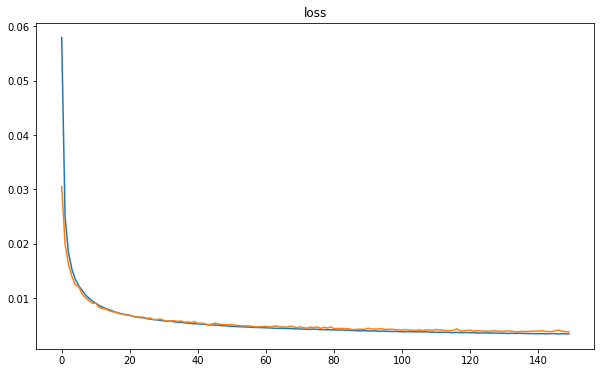

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

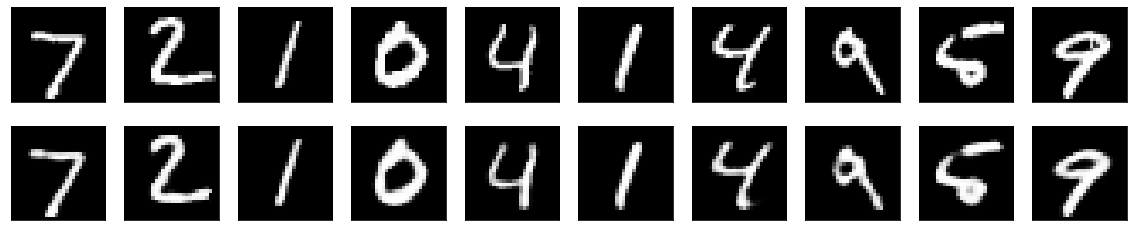

In [0]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## Exercise 5.4: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data, and to check how much it influences the denoising capability of the autoencoder.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

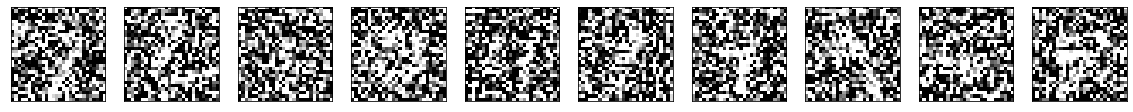

In [0]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**To_complete: use the same model defined in the exercise 5.3.**

In [0]:
######hyperparameters#####################################
epoch_deep_autoencoder=50
layer_encoded = 4
layer_decoded = (layer_encoded -2)
activation_function="relu"
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_function=["mse","binary_crossentropy"]
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
##########################################################


input_img = tf.keras.layers.Input(shape=(784,))
layer_start_encoded = input_img
encoded=[]
i = 1
h= 512
print("\n\nEncoding\n\n")
while i <= layer_encoded:
  print(f"Layer n°{i} Encoding with activation function: {activation_function} and number of units: {str(h)}")
  encoded.append(tf.keras.layers.Dense(int(h), activation=activation_function)(layer_start_encoded))
  layer_start_encoded = encoded[-1]
  i = i + 1
  h = h /2


layer_start_decoded =encoded[-1]
decoded=[]
j = 1
h = h * 4
print("\n\nDecoding\n\n")
while j <= (layer_decoded):
  print(f"Layer n°{j} Decoding with activation function: {activation_function} and number of units: {str(h)}")
  decoded.append(tf.keras.layers.Dense(int(h), activation=activation_function)(layer_start_decoded))
  layer_start_decoded = decoded[-1]
  j = j + 1
  h = h * 2

decoded_finale= tf.keras.layers.Dense(784, activation='sigmoid')(decoded[-1])
print(f"Layer n°{j} Decoding with activation function: sigmoid and number of units: 784")
autoencoder = tf.keras.models.Model(input_img, decoded_finale)
autoencoder.compile(optimizer=opt, loss=loss_function[0])



Encoding


Layer n°1 Encoding with activation function: relu and number of units: 512
Layer n°2 Encoding with activation function: relu and number of units: 256.0
Layer n°3 Encoding with activation function: relu and number of units: 128.0
Layer n°4 Encoding with activation function: relu and number of units: 64.0


Decoding


Layer n°1 Decoding with activation function: relu and number of units: 128.0
Layer n°2 Decoding with activation function: relu and number of units: 256.0
Layer n°3 Decoding with activation function: sigmoid and number of units: 784


In [0]:
autoencoder.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_31 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_35 (Dense)             (None, 256)               330

**To complete: Train the model by passing the noisy input and the clean target.**

In [0]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='loss',patience=10,),
                 keras.callbacks.ModelCheckpoint(filepath='my_model.h5',monitor='val_loss',save_best_only=True)
                 ]
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=epoch_deep_autoencoder,
                batch_size=256,
                shuffle=True,
                callbacks=callbacks_list,
                validation_data=(x_test, x_test))

Epoch 1/50
196/196 [==============================] - 2s 8ms/step - loss: 0.0709 - val_loss: 0.1035
Epoch 2/50
196/196 [==============================] - 1s 7ms/step - loss: 0.0529 - val_loss: 0.0499
Epoch 3/50
196/196 [==============================] - 1s 8ms/step - loss: 0.0448 - val_loss: 0.0449
Epoch 4/50
196/196 [==============================] - 2s 8ms/step - loss: 0.0421 - val_loss: 0.0420
Epoch 5/50
196/196 [==============================] - 1s 8ms/step - loss: 0.0398 - val_loss: 0.0416
Epoch 6/50
196/196 [==============================] - 1s 7ms/step - loss: 0.0383 - val_loss: 0.0406
Epoch 7/50
196/196 [==============================] - 1s 7ms/step - loss: 0.0372 - val_loss: 0.0384
Epoch 8/50
196/196 [==============================] - 1s 7ms/step - loss: 0.0360 - val_loss: 0.0378
Epoch 9/50
196/196 [==============================] - 2s 8ms/step - loss: 0.0351 - val_loss: 0.0353
Epoch 10/50
196/196 [==============================] - 1s 7ms/step - loss: 0.0340 - val_loss: 0.0360

313/313 - 0s - loss: 0.0382
test mse: 0.03817


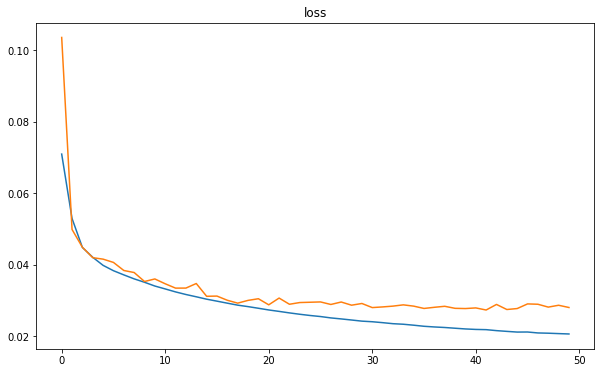

In [0]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

Check the result by plotting some input images and the correspondent denoised outputs

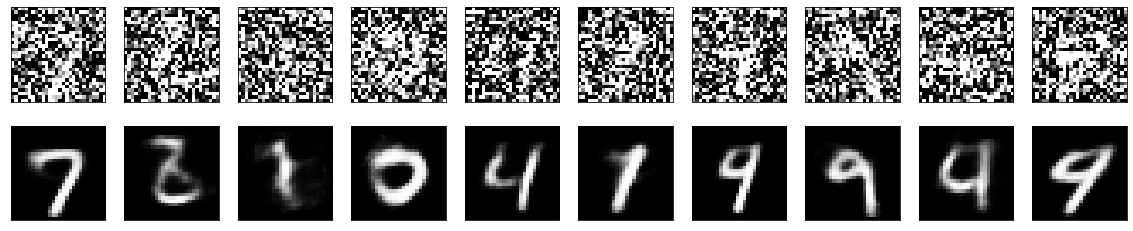

In [0]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [0]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by the IMDB dataset loader, we use the to_categorical method to transform them in the correspondent one-hot representations.

In [0]:
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in exercise 5.1, while the encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense layer on each time step of the sequence. 

Since the output will be a one-hot representation, let's use the binary_crossentropy as loss and the CategoricalAccuracy as metric.

In [0]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 90, 50)            7550      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 2s 30ms/step - loss: 0.1471 - categorical_accuracy: 0.2009 - val_loss: 0.0751 - val_categorical_accuracy: 0.4203
Epoch 2/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0644 - categorical_accuracy: 0.4673 - val_loss: 0.0572 - val_categorical_accuracy: 0.5198
Epoch 3/50
79/79 [==============================] - 2s 29ms/step - loss: 0.0518 - categorical_accuracy: 0.5479 - val_loss: 0.0477 - val_categorical_accuracy: 0.5531
Epoch 4/50
79/79 [==============================] - 2s 29ms/step - loss: 0.0440 - categorical_accuracy: 0.5758 - val_loss: 0.0421 - val_categorical_accuracy: 0.5795
Epoch 5/50
79/79 [==============================] - 2s 28ms/step - loss: 0.0423 - categorical_accuracy: 0.6084 - val_loss: 0.0394 - val_categorical_accuracy: 0.6168
Epoch 6/50
79/79 [==============================] - 2s 29ms/step - loss: 0.0362 - categorical_accuracy: 0.6312 - val_loss: 0.0346 - val_categorical_accuracy: 0.6390
Epoch 7/50

Let's plot the accuracy and the loss curves and check the reconstruction capability of the model by plotting the reconstruction of a test sample.

40/40 - 0s - loss: 0.0112 - categorical_accuracy: 0.9328
categorical_accuracy: 93.28%


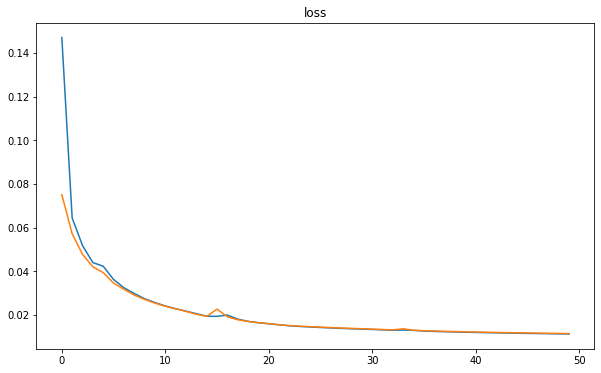

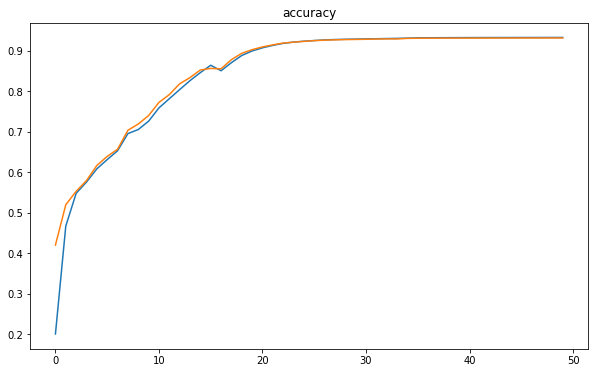

In [0]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [0]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
have a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in all about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> he this <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##Exercise 5.5: Non-Linear Autoencoder for sequences

**To complete: Replicate the code of the exercise above, but instead of using a simpleRNN with linear activations do use non-linear activation functions and a LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.**

**Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.**


In [0]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, activation='sigmoid', return_sequences=True)(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=150, batch_size=256, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/150
40/40 [==============================] - 3s 87ms/step - loss: 0.5481 - categorical_accuracy: 0.0028 - val_loss: 0.3064 - val_categorical_accuracy: 0.4472
Epoch 2/150
40/40 [==============================] - 3s 87ms/step - loss: 0.1586 - categorical_accuracy: 0.4701 - val_loss: 0.0812 - val_categorical_accuracy: 0.4614
Epoch 3/150
40/40 [==============================] - 3s 87ms/step - loss: 0.0655 - categorical_accuracy: 0.4710 - val_loss: 0.0557 - val_categorical_accuracy: 0.4614
Epoch 4/150
40/40 [==============================] - 3s 87ms/step - loss: 0.0513 - categorical_accuracy: 0.4710 - val_loss: 0.0483 - val_categorical_accuracy: 0.4614
Epoch 5/150
40/40 [==============================] - 3s 86ms/step - loss: 0.0461 - categorical_accuracy: 0.4710 - val_loss: 0.0448 - val_categorical_accuracy: 0.4614
Epoch 6/150
40/40 [==============================] - 3s 87ms/step - loss: 0.0434 - categorical_accuracy: 0.4710 - val_loss: 0.0428 - val_categorical_accuracy: 0.4614
Epoc

40/40 - 0s - loss: 0.0013 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


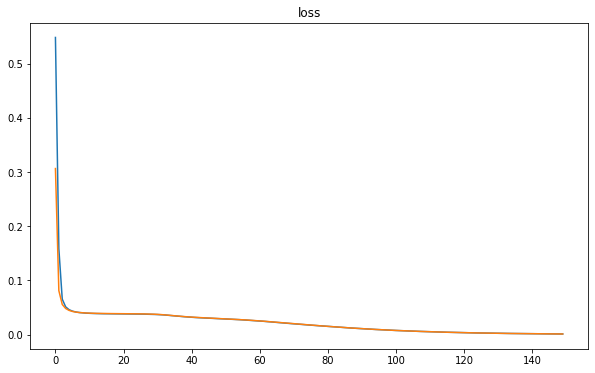

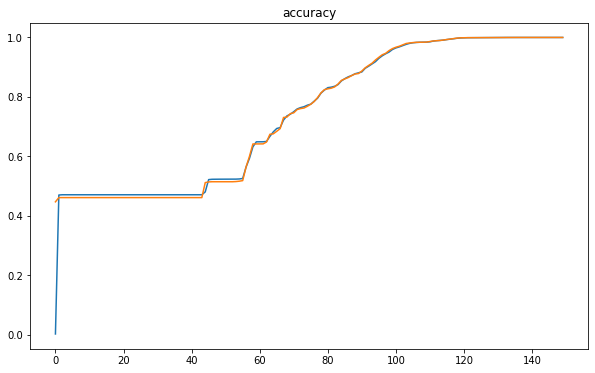

In [0]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [0]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


#**Discussion**


I tried different combinations of activation functions. In the end the one that led me to the best result was sigmoid. Since the output vectors are one-hot coded, they are somehow vectors of binary values. So using a sigmoid activation function whose values are between 0 and 1 can make sense. 






However, not only did I change the recurrent neural network (LSTM) type and the linear non-linear activation function, but I also changed the epoch number to 150 and increased the batch size to 256. I noticed that for a bit of epoch the categorical accuracy value remained stable at about 0.47 and then after the 44 epoch started to rise to 1. So I chose a high number of epochs also because if I wanted 50 I would have a worse result. 






Also the number of parameters of the LSTM model compared to the previous one is triple so it's even more complicated, although I used the same number of neurons.
